Max MMB user bit rate is 8.665312500000002 [Mbit/s]
Max IoT user bit rate is 0.20700468750000003 [Mbit/s]


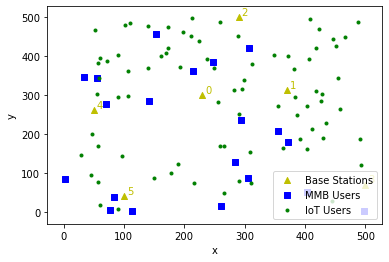

In [1]:
import users2bs
import pandas as pd

# Loading Base Stations
bs = pd.read_csv("./datasets/BS.csv")

# Number of users to generate
tot_users = 100

# Getting max bs x and y
max_x, max_y = bs.x.max(), bs.y.max()

# IoT users percent (of tot_users)
iot_users_percent = 0.8

user_gen_order = users2bs.UserGenOrder.SHUFFLE

# Generating users in random locations
users_generator = users2bs.UsersGenerator(max_x, max_y, tot_users, iot_users_percent)
users = users_generator.generate_users(user_gen_order)

print('Max MMB user bit rate is', users2bs.mmb_user.get_max_bit_rate(), '[Mbit/s]')
print('Max IoT user bit rate is', users2bs.iot_user.get_max_bit_rate(), '[Mbit/s]')

users2bs.plot_positions(bs, users)

Network bit rate is 79.87973906250002 [Mbit/s]
Users disconnected: 38.0 %


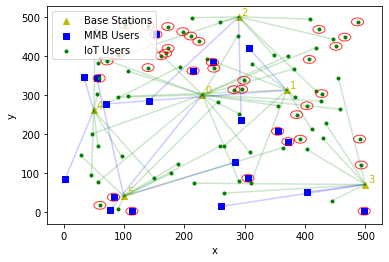

In [2]:
# Computing path loss
path_losses = users2bs.compute_path_losses(bs, users)

# Computing minimum path loss connections
min_path_loss_connections = users2bs.compute_min_path_losses_connections(bs, path_losses)  

# Showing minimum path loss solution
users2bs.show_solution(bs, users, min_path_loss_connections, tot_users)

Network bit rate is 80.18302500000001 [Mbit/s]
Users disconnected: 46.0 %


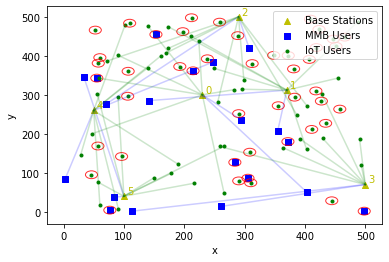

In [3]:
# Sorting users (first MMB)
first_mmb_users = users_generator.order_users(users, users2bs.UserGenOrder.FIRST_MMB)

# Computing first MMB path losses
first_mmb_path_losses = users2bs.compute_path_losses(bs, first_mmb_users)

# Computing minimum path loss connections
first_mmb_min_path_loss_connections = users2bs.compute_min_path_losses_connections(bs, first_mmb_path_losses)  

# Showing minimum path loss solution
users2bs.show_solution(bs, first_mmb_users, first_mmb_min_path_loss_connections, tot_users)

Network bit rate is 55.55428125000002 [Mbit/s]
Users disconnected: 14.000000000000002 %


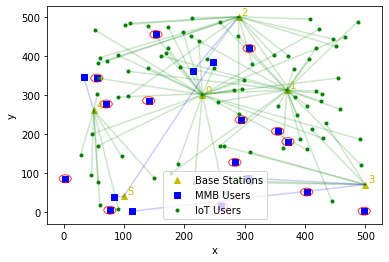

In [4]:
# Sorting users (first IoT)
first_iot_users = users_generator.order_users(users, users2bs.UserGenOrder.FIRST_IOT)

# Computing first IoT path losses
first_iot_path_losses = users2bs.compute_path_losses(bs, first_iot_users)

# Computing first IoT minimum path loss connections
first_iot_min_path_loss_connections = users2bs.compute_min_path_losses_connections(bs, first_iot_path_losses)  

# Showing first IoT minimum path loss solution
users2bs.show_solution(bs, first_iot_users, first_iot_min_path_loss_connections, tot_users)

Network bit rate is 55.52539687500001 [Mbit/s]
Users disconnected: 54.0 %


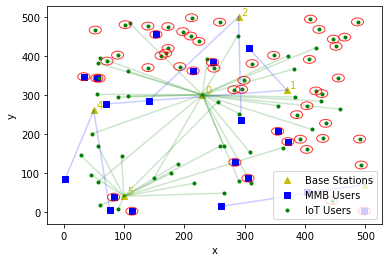

In [5]:
# Setting exclusive BS (accept only MMB or IoT users)
users2bs.is_bs_exclusive = True

# Computing path loss
exclusive_path_losses = users2bs.compute_path_losses(bs, users)

# Computing minimum path loss connections
exclusive_min_path_loss_connections = users2bs.compute_min_path_losses_connections(bs, exclusive_path_losses)  

# Showing minimum path loss solution
users2bs.show_solution(bs, users, exclusive_min_path_loss_connections, tot_users)

# Resetting exclusive BS
users2bs.is_bs_exclusive = False

In [ ]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier
import pickle

predictor = users2bs.UsersAllocationPredictor(bs, 'genetic', KNeighborsClassifier(n_neighbors=5))

reload_model = False
filename = 'finalized_model.sav'

if reload_model:
        predictor.classifier = pickle.load(open(filename, 'rb'))
else:
    accuracy = predictor.train(1000, tot_users, iot_users_percent)
    pickle.dump(predictor.classifier, open(filename, 'wb'))
    print('Model accuracy:', accuracy)

Generation: 1
Total bit rate: 93.18099375000008 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 97.51365000000008 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 90.40809375000009 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 90.71137968750014 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 92.87770781250008 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 92.87770781250009 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 86.07543750000013 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 92.87770781250012 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 91.01466562500009 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 86.37872343750007 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 88.24176562500013 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 104.0126343750001 [Mbit/s]
Users disconnected:

Generation: 1
Total bit rate: 92.8777078125001 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 97.21036406250009 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 92.27113593750013 [Mbit/s]
Users disconnected: 22.0 %
Generation: 1
Total bit rate: 94.7407500000001 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 83.90910937500014 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 86.37872343750013 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 90.71137968750013 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 97.21036406250013 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 95.04403593750013 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 95.3473218750001 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 92.87770781250012 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 101.54302031250009 [Mbit/s]
Users disconnected: 3

Generation: 1
Total bit rate: 99.6799781250001 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 94.74075000000013 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 88.54505156250013 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 88.54505156250012 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 86.07543750000013 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 88.5450515625001 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 93.18099375000011 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 99.67997812500008 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 94.74075000000015 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 108.3452906250001 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 88.54505156250008 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 101.84630625000011 [Mbit/s]
Users disconnected: 

Generation: 1
Total bit rate: 86.07543750000009 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 91.01466562500009 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 77.41012500000008 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 99.6799781250001 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 87.93847968750016 [Mbit/s]
Users disconnected: 22.0 %
Generation: 1
Total bit rate: 92.87770781250012 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 93.18099375000011 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 99.37669218750013 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 83.90910937500011 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 112.6779468750001 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 95.3473218750001 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 90.40809375000009 [Mbit/s]
Users disconnected: 3

Generation: 1
Total bit rate: 95.04403593750013 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 99.07340625000018 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 97.21036406250015 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 90.40809375000015 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 86.07543750000013 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 88.54505156250016 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 92.87770781250006 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 92.87770781250012 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 90.40809375000018 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 97.21036406250009 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 86.37872343750006 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 91.01466562500013 [Mbit/s]
Users disconnected:

Generation: 1
Total bit rate: 105.87567656250012 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 94.74075000000012 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 99.67997812500005 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 97.21036406250008 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 92.87770781250008 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 86.37872343750014 [Mbit/s]
Users disconnected: 38.0 %
Generation: 1
Total bit rate: 86.07543750000018 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 88.8483375000001 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 97.51365000000011 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 88.24176562500011 [Mbit/s]
Users disconnected: 30.0 %
Generation: 1
Total bit rate: 88.84833750000008 [Mbit/s]
Users disconnected: 46.0 %
Generation: 1
Total bit rate: 99.67997812500009 [Mbit/s]
Users disconnected:

In [ ]:
# Predicting connections for test users
connections_prediction = predictor.predict(users)

# Adjusting minimum path loss connections (because prediction doesn't consider max BSs PRB constraints)
connections_prediction = users2bs.adjust_min_path_loss_connections(predictor.bs, connections_prediction)

# Showing KNN solutions
users2bs.show_solution(predictor.bs, users, connections_prediction, tot_users)

In [ ]:
# Classification Data
# 
# Column 0: age
# Column 1: likes pineapple
clf_data = [
   [22, 1],
   [23, 0],
   [21, 2],
   [18, 3],
   [19, 4],
   [25, 0],
   [27, 0],
   [29, 1],
   [31, 2],
   [45, 3],
]
# Question:
# Given the data we have, does a 33 year old like pineapples on their pizza?
clf_query = [33]
clf_k_nearest_neighbors, clf_prediction = users2bs.knn(
    clf_data, clf_query, k=3, distance_fn=users2bs.euclidean_distance, choice_fn=users2bs.mode
)

print(clf_k_nearest_neighbors, clf_prediction)